<a href="https://colab.research.google.com/github/wamiqulislam/Car_Price_Predictor/blob/main/Data_analysis%2C_model_training_%26_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [93]:
import pandas as pd
import numpy as np
import re
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import joblib

#Inputs

In [94]:
#=======================Make Changes Here=======================================

# paste in the path to the csv file containing the data
dataset_path = "/content/Mehran_ads_data.csv"
df = pd.read_csv(dataset_path)

# Brand and Model to make model for, set use_all_data to use all brands and models data in the file
use_all_data = False
brand = "Suzuki"
car = "Mehran"

#final results with price comparisons file path
save_path = f"{brand}_{car}_results.csv"
#===============================================================================

#Chooose Brand and Model

In [95]:
if not use_all_data:
    df = df[(df["Brand"] == brand) & (df["Model"] == car)]

df.head()

,Name,City,Brand,Model,Year,Mileage,Fuel,Transmission,Engine Capacity,Color,Body Type,Price,Ad URL,Description,Registered In,Assembly,Last Updated:,Ad Ref #,Features,Seller Comments
0,Suzuki Mehran 2013 for sale in Islamabad,Islamabad,Suzuki,Mehran,2013,"11,809 km",Petrol,Manual,796 cc,Sand Beige,Hatchback,1450000 PKR,https://www.pakwheels.com/used-cars/suzuki-meh...,Seats Cover\r\nPakWheels inspected car\r\nInsp...,Islamabad,Local,"Aug 21, 2025",10467187,"['AM/FM Radio', 'CD Player', 'Front Speakers',...",Seats Cover PakWheels inspected car Inspection...
1,Suzuki Mehran 2012 for sale in Islamabad,Islamabad,Suzuki,Mehran,2012,"92,650 km",Petrol,Manual,800 cc,Snow White Pearl,Hatchback,1000000 PKR,https://www.pakwheels.com/used-cars/suzuki-meh...,-alloy wheels installed \r\n- PakWheels inspec...,Islamabad,Local,"Aug 21, 2025",10400207,"['Front Speakers', 'USB and Auxillary Cable']",-alloy wheels installed - PakWheels inspected ...
2,Suzuki Mehran 2018 for sale in Islamabad,Islamabad,Suzuki,Mehran,2018,"52,000 km",Petrol,Manual,796 cc,Silky Silver,Hatchback,1395000 PKR,https://www.pakwheels.com/used-cars/suzuki-meh...,a,Lahore,Local,"Aug 21, 2025",10487071,"['AM/FM Radio', 'Air Conditioning', 'CD Player...",a Mention PakWheels.com when calling Seller to...
3,Suzuki Mehran 2007 for sale in Islamabad,Islamabad,Suzuki,Mehran,2007,"62,570 km",Petrol,Manual,800 cc,Blue,Hatchback,850000 PKR,https://www.pakwheels.com/used-cars/suzuki-meh...,Floor Matts\r\nPakWheels inspected car\r\nInsp...,Lahore,Local,"Aug 21, 2025",10422652,"['AM/FM Radio', 'Front Speakers', 'USB and Aux...",Floor Matts PakWheels inspected car Inspection...
4,Suzuki Mehran 2017 for sale in Islamabad,Islamabad,Suzuki,Mehran,2017,"58,000 km",Petrol,Manual,800 cc,Silver,Hatchback,1375000 PKR,https://www.pakwheels.com/used-cars/suzuki-meh...,Suzuki Mehran Euro 2 \r\nGare 100 % Total Genu...,Lahore,Local,"Aug 21, 2025",10477268,"['AM/FM Radio', 'Air Conditioning', 'CD Player...",Suzuki Mehran Euro 2 Gare 100 % Total Genuine ...


#Cleaning

In [96]:
df.fillna(0)

# Clean mileage (e.g. "52,000 km" -> 52000)
def clean_mileage(x):
    if pd.isna(x): return np.nan
    return int(re.sub(r"[^\d]", "", str(x))) if re.search(r"\d", str(x)) else np.nan
df["Mileage"] = df["Mileage"].apply(clean_mileage)

# Clean engine_cc (e.g. "796 cc" -> 796)
def clean_engine(x):
    if pd.isna(x): return np.nan
    return int(re.sub(r"[^\d]", "", str(x))) if re.search(r"\d", str(x)) else np.nan
df["Engine Capacity"] = df["Engine Capacity"].apply(clean_engine)

# Clean price (e.g. "1,395,000 PKR" -> 1395000)
def clean_price(x):
    if pd.isna(x): return np.nan
    return int(re.sub(r"[^\d]", "", str(x))) if re.search(r"\d", str(x)) else np.nan
df["Price"] = df["Price"].apply(clean_price)


In [97]:
# Standardize colors
def clean_color(x):
    if pd.isna(x): return "Unknown"
    x = str(x).lower()
    if "silver" in x: return "Silver"
    if "white" in x: return "White"
    if "blue" in x: return "Blue"
    if "grey" in x or "gray" in x: return "Grey"
    if "black" in x: return "Black"
    if "red" in x: return "Red"
    if "yellow" in x: return "Yellow"
    return x.title()

df["Color"] = df["Color"].apply(clean_color)

#Feature Processing

In [98]:
# Parse features list
def parse_features(x):
    if pd.isna(x): return []
    try:
        return ast.literal_eval(x) if isinstance(x, str) else []
    except:
        return []
df["FeaturesList"] = df["Features"].apply(parse_features)

# Convert to binary columns
mlb = MultiLabelBinarizer()
features_binary = mlb.fit_transform(df["FeaturesList"])
features_df = pd.DataFrame(features_binary, columns=mlb.classes_, index=df.index)
df = pd.concat([df, features_df], axis=1)


In [99]:
CURRENT_YEAR = 2025

# Car age
df["CarAge"] = CURRENT_YEAR - df["Year"]

# Mileage per year
df["MileagePerYear"] = df["Mileage"] / df["CarAge"].replace(0, 1)


#Insights

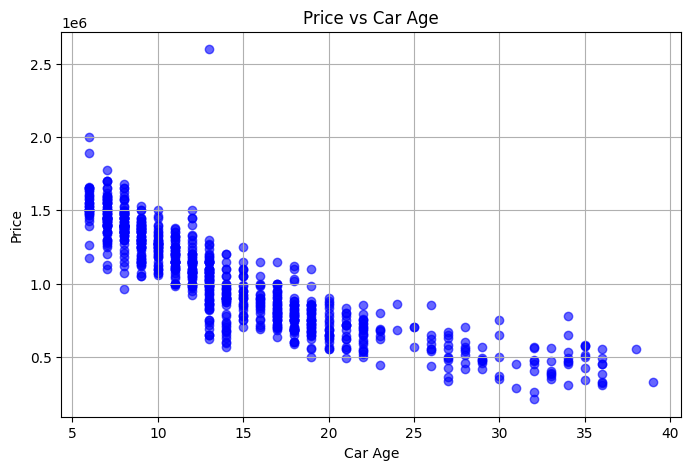

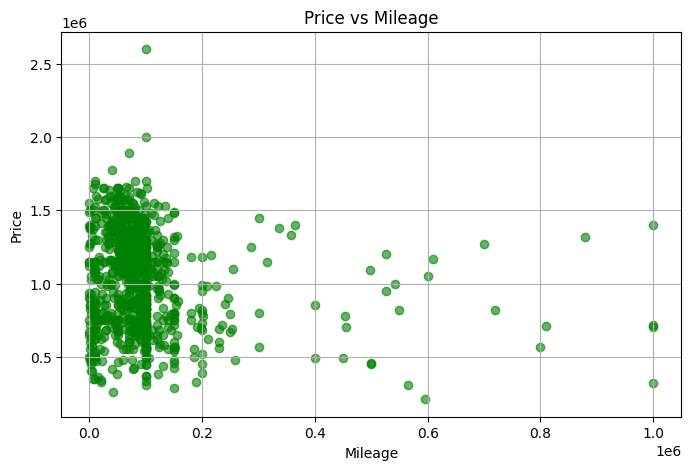

In [100]:
import pandas as pd
import matplotlib.pyplot as plt

# Example DataFrame
df_plot = df[["CarAge", "Mileage", "Price"]].copy()

# Plot 1: CarAge vs Price
plt.figure(figsize=(8,5))
plt.scatter(df_plot["CarAge"], df_plot["Price"], color='blue', alpha=0.6)
plt.xlabel("Car Age")
plt.ylabel("Price")
plt.title("Price vs Car Age")
plt.grid(True)
plt.show()

# Plot 2: Mileage vs Price
plt.figure(figsize=(8,5))
plt.scatter(df_plot["Mileage"], df_plot["Price"], color='green', alpha=0.6)
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.title("Price vs Mileage")
plt.grid(True)
plt.show()


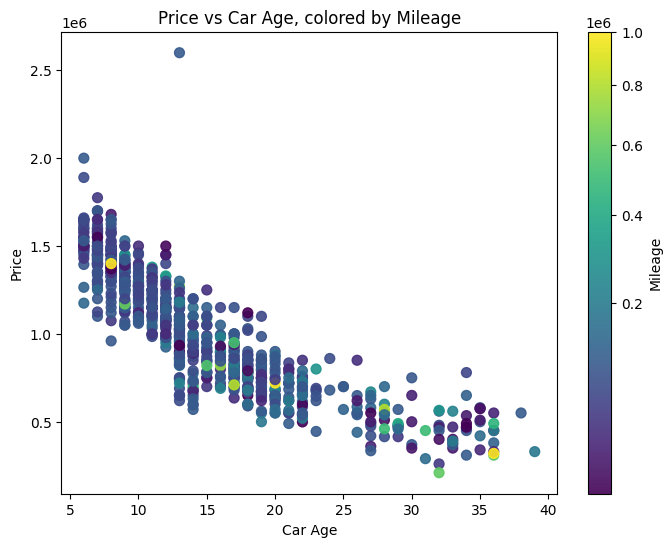

In [101]:
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm

x = df['CarAge']
y = df['Price']
color_val = df['Mileage']  # the variable to map to color

plt.figure(figsize=(8,6))
sc = plt.scatter(
    x, y,
    c=color_val,
    cmap='viridis',
    norm=PowerNorm(gamma=0.55),  # gamma <1 emphasizes lower values
    s=50,
    alpha=0.9
)
plt.xlabel('Car Age')
plt.ylabel('Price')
plt.title('Price vs Car Age, colored by Mileage')
plt.colorbar(sc, label='Mileage')
plt.show()


#Train/Test

In [102]:
# Features (include binary feature columns dynamically)
feature_cols = list(mlb.classes_)

X = df[["City", "Mileage", "Fuel", "Transmission", "Engine Capacity",
        "Color", "CarAge", "Registered In", "Assembly"] + feature_cols]
y = df["Price"]

X.head()

# Categorical & numeric cols
categorical_cols = ["City", "Fuel", "Transmission", "Color", "Registered In", "Assembly"]
numeric_cols = ["Mileage", "Engine Capacity", "CarAge"] + feature_cols

# Preprocessor
preprocessor = ColumnTransformer([
    ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ("numeric", StandardScaler(), numeric_cols)
])


In [103]:
df.shape

(870, 46)

#Model Training

In [104]:
# Model pipeline
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=300, random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
model.fit(X_train, y_train)


joblib.dump(model, f"{brand}_{car}_model.pkl")
print(f"Model saved to {brand}_{car}_model.pkl")
joblib.dump(mlb, f"{brand}_{car}_mlb.pkl")
print(f"MLB saved to {brand}_{car}_mlb.pkl")


Model saved to Suzuki_Mehran_model.pkl
MLB saved to Suzuki_Mehran_mlb.pkl


#Eval

In [105]:

# Predictions
y_pred = model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100


print(f"MAE: {mae:,.0f}")
print(f"RMSE: {rmse:,.0f}")
print(f"R²: {r2:.3f}")
print(f"mape: {mape:,.2f}")


MAE: 91,263
RMSE: 118,269
R²: 0.862
mape: 9.98


#Finding best priced car

In [106]:
import pandas as pd
import numpy as np

# Predictions
y_pred = model.predict(X)

# Build results DataFrame
results = pd.DataFrame({
    "Name": df.loc[y.index, "Name"],
    "Description": df.loc[y.index, "Description"],
    "Seller Comments": df.loc[y.index, "Seller Comments"],
    "City": df.loc[y.index, "City"],
    "Brand": df.loc[y.index, "Brand"],
    "Model": df.loc[y.index, "Model"],
    "Year": df.loc[y.index, "Year"],
    "Mileage": df.loc[y.index, "Mileage"],
    "Actual Price": y,
    "Predicted Price": y_pred,
    "Absolute Error": y - y_pred,
    "Percentage Error (%)": ((y - y_pred) / y) * 100,
    "Ad URL": df.loc[y.index, "Ad URL"]
}).reset_index(drop=True)

# Sort by biggest (negative) price difference
results_sorted = results.sort_values(by="Absolute Error", ascending=True).reset_index(drop=True)

print(results_sorted.head(5))   # best predicted 10 cars

# Save to CSV
results_sorted.to_csv(save_path, index=False, encoding="utf-8-sig")
print(f'results saved to {save_path}')


                                       Name  \
0  Suzuki Mehran 2006 for sale in Islamabad   
1  Suzuki Mehran 2012 for sale in Islamabad   
2  Suzuki Mehran 2014 for sale in Islamabad   
3  Suzuki Mehran 1993 for sale in Islamabad   
4  Suzuki Mehran 2012 for sale in Islamabad   

                                         Description  \
0  Showered, on my own name, mechanically fit, no...   
1  power staring allow rim good tire new car tota...   
2  neat & clean home used car  urgent sale  . Chi...   
3  Suzuki mehran 1993 modle my family used car in...   
4  Mechanical Okay \nMehran VXR: Non EFI\nNo Majo...   

                                     Seller Comments       City   Brand  \
0  Showered, on my own name, mechanically fit, no...  Islamabad  Suzuki   
1  power staring allow rim good tire new car tota...  Islamabad  Suzuki   
2  neat & clean home used car  urgent sale  . Chi...  Islamabad  Suzuki   
3  Suzuki mehran 1993 modle my family used car in...  Islamabad  Suzuki   
4  Me